# Machine Learning Applications for Airbnb Data

### Group 3 - Dhruv Shah, Jenn Hong, Setu Shah, Sonya Dreyer

---



• State the problem

• Tell us who cares about this problem and Why

• Describe your data – where it came from, what it contains

• Present some interesting descriptive analyses (plots/tables) that motivates your exercise

• Present your main results

• Which methods worked best for your problem?

• What were the challenges you faced? Tell us about the biggest challenge you faced and how you
overcame it (or, tried but did not – that’s fine too – not every problem has a solution.)

• Conclude – what have you learnt that can be put to practice?

# Data Cleaning

---



In [1]:
# Import preprocessing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Download the file

!wget 'https://maven-datasets.s3.amazonaws.com/Airbnb/Airbnb+Data.zip'

--2023-12-03 01:49:43--  https://maven-datasets.s3.amazonaws.com/Airbnb/Airbnb+Data.zip
Resolving maven-datasets.s3.amazonaws.com (maven-datasets.s3.amazonaws.com)... 3.5.8.176, 52.216.218.177, 3.5.25.128, ...
Connecting to maven-datasets.s3.amazonaws.com (maven-datasets.s3.amazonaws.com)|3.5.8.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91005234 (87M) [application/zip]
Saving to: ‘Airbnb+Data.zip’

Airbnb+Data.zip     100%[===================>]  86.79M  23.8MB/s    in 3.7s    

2023-12-03 01:49:47 (23.8 MB/s) - ‘Airbnb+Data.zip’ saved [91005234/91005234]



In [3]:
# Unzip the file

!unzip Airbnb+Data.zip

Archive:  Airbnb+Data.zip
   creating: Airbnb Data/
  inflating: Airbnb Data/Listings.csv  
  inflating: Airbnb Data/Listings_data_dictionary.csv  
  inflating: Airbnb Data/Reviews.csv  
  inflating: Airbnb Data/Reviews_data_dictionary.csv  


In [17]:
# Load the data frames

listings =  pd.read_csv('/content/Airbnb Data/Listings.csv', encoding = 'latin1', low_memory = False)

#reviews = pd.read_csv('/content/Airbnb Data/Reviews.csv', encoding = 'latin1', low_memory = False)

In [18]:
# Taking a random sample of the data for easier analysis

listings_sample = listings.sample(100000, random_state = 42)

In [19]:
listings_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 179118 to 255375
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   100000 non-null  int64  
 1   name                         99929 non-null   object 
 2   host_id                      100000 non-null  int64  
 3   host_since                   99933 non-null   object 
 4   host_location                99704 non-null   object 
 5   host_response_time           54163 non-null   object 
 6   host_response_rate           54163 non-null   float64
 7   host_acceptance_rate         59780 non-null   float64
 8   host_is_superhost            99933 non-null   object 
 9   host_total_listings_count    99933 non-null   float64
 10  host_has_profile_pic         99933 non-null   object 
 11  host_identity_verified       99933 non-null   object 
 12  neighbourhood                100000 non-null  object 

In [21]:
listings_sample.head(3)

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
179118,33440354,"Bangkok Condo close to BTS NANA/Asok , Sukhumv...",21302722,2014-09-14,"Bangkok, Bangkok, Thailand",NaN,NaN,NaN,f,3.0,...,15,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t
187483,46027406,Country Touches Private Bedroom In Upper West ...,373077389,2020-10-23,"New York, New York, United States",within an hour,1.0,1.0,t,1.0,...,1,180,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
17637,9970462,Large East Village Apartment,28336810,2015-02-25,"New York, New York, United States",NaN,NaN,NaN,f,1.0,...,30,1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f


In [24]:
# Converting to datetime

listings_sample.host_since = pd.to_datetime(listings.host_since)

In [25]:
# Converting to out-of-10 scale

listings_sample.review_scores_rating = listings.review_scores_rating / 10

In [26]:
# Converting prices to USD

cities = listings_sample['city'].unique()
exchange_rates = [1.0808, 1, 0.028388, 0.20328, 0.65462, 0.039480, 1.0808, 0.12777, 0.0493, 0.053215] # update these numbers before fitting models
currency_map = dict(zip(cities, exchange_rates))

listings_sample['usd_price'] = listings_sample.apply(lambda row: row['price'] * currency_map[row['city']], axis=1) # create new column
listings_sample.drop('price', axis = 1, inplace = True) # drop original column

In [27]:
# Converting to numerical category

# Potentially problematic -> Converting NULL values to zero

listings_sample.host_is_superhost = listings_sample.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)
listings_sample.host_has_profile_pic = listings_sample.host_has_profile_pic.apply(lambda x: 1 if x == 't' else 0)
listings_sample.host_identity_verified = listings_sample.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)
listings_sample.instant_bookable = listings_sample.instant_bookable.apply(lambda x: 1 if x == 't' else 0)

In [ ]:
# We can or should drop listing_id, host_id, property, neighbourhood

# We can drop Districts as it has only districts of New York, rest are all NULL

# We should drop name and possibly host_location (unless we want to/can figure out how to extract precise location --> latitude and longitude can be used to create clusters like in the lab)

# All host locations within each country have been mapped to the most prominent city in that country

# We need to possibly impute values (or drop columns) for host response time/rate, host_acceptance_rate, and some of the ratings columns [Iterative Imputer]

In [29]:
listings_sample.head(2).T

,179118,187483
listing_id,33440354,46027406
name,"Bangkok Condo close to BTS NANA/Asok , Sukhumv...",Country Touches Private Bedroom In Upper West ...
host_id,21302722,373077389
host_since,2014-09-14 00:00:00,2020-10-23 00:00:00
host_location,"Bangkok, Bangkok, Thailand","New York, New York, United States"
host_response_time,NaN,within an hour
host_response_rate,NaN,1.0
host_acceptance_rate,NaN,1.0
host_is_superhost,0,1
host_total_listings_count,3.0,1.0


In [75]:
listings_sample.instant_bookable.value_counts()

0    58716
1    41284
Name: instant_bookable, dtype: int64

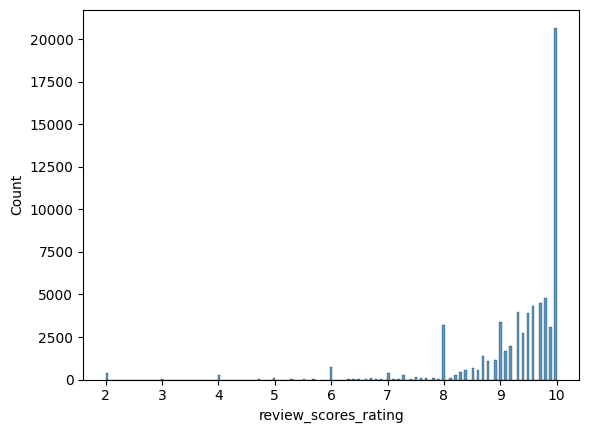

In [72]:
sns.histplot(listings_sample, x = 'review_scores_rating');

<Axes: xlabel='review_scores_rating'>

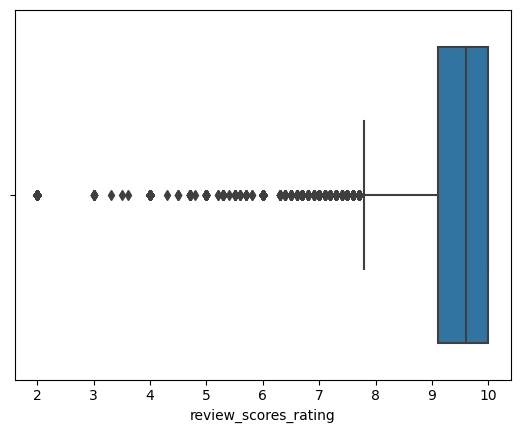

In [71]:
sns.boxplot(listings_sample, x = 'review_scores_rating')

In [52]:
listings_sample['host_total_listings_count'].value_counts()[0:10]

1.0       41791
2.0       12755
0.0       11912
3.0        6271
4.0        4056
          ...  
251.0         1
7211.0        1
222.0         1
157.0         1
161.0         1
Name: host_total_listings_count, Length: 184, dtype: int64

In [74]:
listings_sample['review_scores_rating'].isna().sum()

32589

In [51]:
listings_sample[listings_sample['host_total_listings_count'] == 0]

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,usd_price
166994,43769646,"Private room in apartment. ""DÃÂ­a de Muertos""...",131221509,2017-05-20,"Mexico City, Mexico City, Mexico",within an hour,1.0,0.90,1,0.0,...,30,9.0,10.0,10.0,10.0,10.0,10.0,9.0,0,9.47520
100798,44549152,Enjoy Roma as a local! the best neighbour to l...,46540728,2015-10-14,"Montalbano, Emilia-Romagna, Italy",NaN,NaN,NaN,0,0.0,...,1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,54.04000
58085,40933556,Apartamento em Copacabana,318920119,2019-12-19,BR,NaN,NaN,NaN,0,0.0,...,1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31.94250
247045,4345550,Duplex charme St Germain des PrÃÂ¨s,22555807,2014-10-15,"Paris, Ile-de-France, France",within a day,1.0,1.00,0,0.0,...,30,9.6,10.0,9.0,10.0,10.0,10.0,10.0,0,229.11700
85051,43920471,"Luxury Studio at Asok&Nana BTS Station, Sukhumvit",179723003,2018-03-21,"Bangkok, Bangkok, Thailand",a few days or more,0.5,0.63,0,0.0,...,1125,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1,626.86400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234771,28907165,Charmant appartement - Abbesses,23103432,2014-10-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,0,0.0,...,4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,58.91580
56863,40221162,Cosy and modern whole apartment,56753275,2016-01-30,"Buenos Aires, Autonomous City of Buenos Aires,...",NaN,NaN,NaN,0,0.0,...,1125,10.0,10.0,10.0,10.0,10.0,8.0,8.0,1,2.55492
108591,43900790,Elio Del Ray,61748483,2016-03-06,"Bangkok, Thailand",a few days or more,0.0,NaN,0,0.0,...,1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,348.01760
172586,34530998,Apartment around the park,260589412,2019-05-08,"New York, New York, United States",within an hour,1.0,0.88,0,0.0,...,21,9.7,10.0,9.0,10.0,10.0,9.0,10.0,0,69.00000


In [12]:
# Dropping hopeless columns

columns_to_drop = ['listing_id', 'host_id', 'property_type', 'neighbourhood', 'district', 'name', 'host_location', 'amenities']

listings_sample = listings_sample.drop(columns=columns_to_drop, axis=1)

In [137]:
# Dropping columns with > 50% missing values

missing_values_columns = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']

listings_sample = listings_sample.drop(columns=missing_values_columns, axis=1)

In [138]:
# Dropping latitude and longitude

listings_sample = listings_sample.drop(columns=['latitude', 'longitude'], axis=1)

In [16]:
listings_sample.skew(axis = 0, numeric_only=True)

host_response_rate              -2.270031
host_acceptance_rate            -1.871278
host_is_superhost                1.662356
host_total_listings_count       23.845350
host_has_profile_pic           -15.716597
host_identity_verified          -0.977378
latitude                        -0.711813
longitude                        0.487746
accommodates                     2.207221
bedrooms                        12.370222
minimum_nights                  16.577005
maximum_nights                 316.176633
review_scores_rating            -3.746942
review_scores_accuracy          -4.163205
review_scores_cleanliness       -2.999510
review_scores_checkin           -5.228129
review_scores_communication     -5.216378
review_scores_location          -4.274060
review_scores_value             -3.240565
instant_bookable                 0.354066
usd_price                       50.204649
dtype: float64

In [107]:
# # Dropping after feature selection

# drop_features = [,  ,  , ]

# listings = listings.drop(columns= drop_features, axis=1)

# Preprocessing

---



In [139]:
# Splitting the data into training and test sets to estimate generalization error

from sklearn.model_selection import train_test_split

X = listings.drop("usd_price", axis=1)
y = listings["usd_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((223769, 19), (55943, 19), (223769,), (55943,))

In [ ]:
# # Iteratively impute missing values for numerical columns

# X_train_num = X_train.select_dtypes(include=[np.number])

# iter_imputer = IterativeImputer(random_state=42)
# X_train_imp = iter_imputer.fit_transform(X_train_num)
# X_train_imp_df = pd.DataFrame(X_train_imp, columns=X_train_num.columns, index=X_train_num.index)

In [140]:
# Building preprocessing pipeline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn import set_config
set_config(display='diagram')

cat_attribs = ['host_identity_verified', 'city', 'instant_bookable', 'host_has_profile_pic', 'room_type', 'host_is_superhost'] # not sure if host_since (maybe split by months) is included here

num_attribs = ['accommodates', 'host_total_listings_count', 'review_scores_rating', 'minimum_nights', 'maximum_nights',  'review_scores_accuracy', 'review_scores_checkin',
               'bedrooms', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value'] # excluding latitude and longitude

# missing_attribs = ['host_total_listings_count', 'bedrooms', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
#                'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

num_pipeline = make_pipeline(IterativeImputer(random_state = 42), StandardScaler())

# Dropping amenities for now

preprocess_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(drop="first"), cat_attribs),
        ("num", num_pipeline, num_attribs),
    ])

preprocess_pipeline

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['host_identity_verified', 'city',
                                  'instant_bookable', 'host_has_profile_pic',
                                  'room_type', 'host_is_superhost']),
                                ('num',
                                 Pipeline(steps=[('iterativeimputer',
                                                  IterativeImputer(random_state=42)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['accommodates', 'host_total_listings_count',
                                  'review_scores_rating', 'minimum_nights',
                                  'maximum_nights', 'review_scores_accuracy',
                                  'review_scores_checkin', 'bedrooms',
                                  'review_scores_cleanliness',
                                  'review_scores_communication',
                                  'review_scores_location',
                                  'review_scores_value'])])

In [ ]:
# # Checking data after pre-processing
# print(X_train.shape)
# X_train_prepared = preprocess_pipeline.fit_transform(X_train)
# print(X_train_prepared.shape)

In [ ]:
# # Checking new column names

# preprocess_pipeline.get_feature_names_out()

In [ ]:
# X_train_prepared_df = pd.DataFrame(X_train_prepared, # the numpy array containing the processed data
#                                    columns=preprocess_pipeline.get_feature_names_out(), # column names
#                                    index=X_train.index # row numbers/labels
#                                    )
# X_train_prepared_df.isna().sum()

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = make_pipeline(preprocess_pipeline, LinearRegression())
lin_reg.fit(X_train, y_train)
y_train_predictions = lin_reg.predict(X_train)

lin_rmse = mean_squared_error(y_train, y_train_predictions, squared=False)
print(f"The training data RMSE is {lin_rmse:.0f} or about {(lin_rmse/y_train.mean()*100):.0f}% error")

The training data RMSE is 433 or about 389% error


In [142]:
from sklearn.metrics import r2_score

print(f'R-squared score from Linear Regression model is {r2_score(y_train, y_train_predictions):.3f}')

R-squared score from Linear Regression model is 0.036


In [ ]:
# from sklearn.tree import DecisionTreeRegressor

# tree_reg = make_pipeline(preprocess_pipeline, DecisionTreeRegressor(random_state=42))
# tree_reg.fit(X_train, y_train)
# y_train_predictions = tree_reg.predict(X_train)
# tree_rmse = mean_squared_error(y_train, y_train_predictions, squared=False)
# print(f'Training data error for the tree {tree_rmse:.0f}')

Training data error for the tree 126


In [ ]:
# #from sklearn.metrics import r2_score

# print(f'R-squared score from Decision Tree model is {r2_score(y_train, y_train_predictions):.3f}')

R-squared score from Decision Tree model is 0.919


In [145]:
# Creating a dataframe of all features and their coefficients

feature_names = X_train.columns

# Access the logistic regression model from the pipeline
lin_model = lin_reg.named_steps['linearregression']

# Get the coefficients and feature names
coefficients = lin_model.coef_

# Create a DataFrame for each variable

dfs = []
for feature_name, coefficient in zip(feature_names, coefficients):
    df = pd.DataFrame({'Feature': [feature_name], 'Coefficient': [coefficient]})
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

In [146]:
# Sorting by absolute values of coefficients

result_df.reindex(result_df['Coefficient'].abs().sort_values(ascending=False).index)

,Feature,Coefficient
5,city,96.357422
9,minimum_nights,76.905919
6,room_type,67.790193
7,accommodates,63.065613
16,review_scores_location,52.280271
12,review_scores_accuracy,51.376065
2,host_total_listings_count,45.158748
3,host_has_profile_pic,-41.786734
8,bedrooms,39.264365
1,host_is_superhost,39.006321


In [147]:
from sklearn.model_selection import cross_val_score

# First for the linear regression
lin_cv_rmses = -cross_val_score(lin_reg, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average Linear Regression Cross-Validation RMSE: {lin_cv_rmses.mean():.0f}")

Average Linear Regression Cross-Validation RMSE: 422


In [ ]:
# # Then the decision tree regressor

# tree_cv_rmses = -cross_val_score(tree_reg, X_train, y_train,
#                               scoring="neg_root_mean_squared_error", cv=3)
# print(f"Average Decision Tree Regression Cross-Validation RMSE: {tree_cv_rmses.mean():.0f}")

Average Decision Tree Regression Cross-Validation RMSE: 531
